In [1]:
!pip install -U -q segmentation-models

In [2]:
import os 
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from glob import glob
import cv2

import tensorflow as tf
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [3]:
# Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes= 11 #Number of classes for segmentation

In [4]:
files_train = glob("C:/Users/nadan/Downloads/archive (1)/*.jpg")
files_train.sort()
files_test = glob("C:/Users/nadan/Downloads/archive (1)/*fuse*")
files_test.sort()

In [5]:
train_images_p, test_images_p, train_masks_p, test_masks_p = train_test_split(files_train, files_test,shuffle=True, test_size = 0.20, random_state = 0)

In [6]:
# Load and preprocess the dataset

def load_images(paths,size_x = SIZE_X, size_y = SIZE_Y):
    #Capture training image info as a list
    train_images = []
    for file in paths:
        img = cv2.imread(file,1)       
        img = cv2.resize(img, (size_y, size_x))
        train_images.append(img)
    train_images = np.array(train_images)
    return train_images

def load_masks(paths,size_x = SIZE_X, size_y = SIZE_Y):
    # Capture mask/label info as a list
    train_masks = [] 
    for file in paths:
        mask = cv2.imread(file, 0)       
        mask = cv2.resize(mask, (size_y, size_x), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
    #Convert list to array for machine learning processing          
    train_masks = np.array(train_masks)
    return train_masks


In [7]:
train_images = load_images(train_images_p)
# train_images = np.stack((train_images,) * 3, axis = -1)

In [8]:
train_masks = load_masks(train_masks_p)

Image Train example:


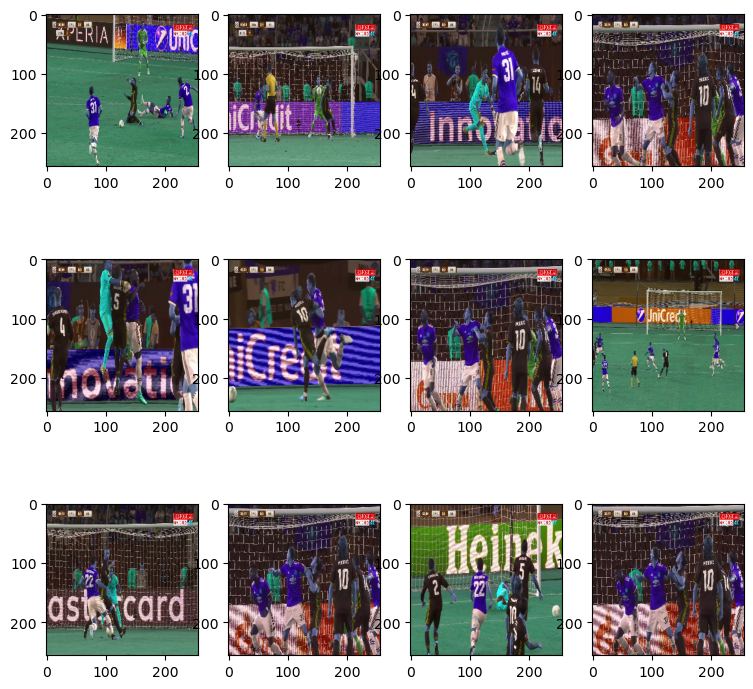

In [9]:
img = train_images[0:12]
print("Image Train example:")
plt.figure(figsize = (9,9))

for i in range(0, 12):
    image = img[i]
    plt.subplot(3,4, i + 1)
    plt.imshow(image) 

plt.show();

Image Train example:


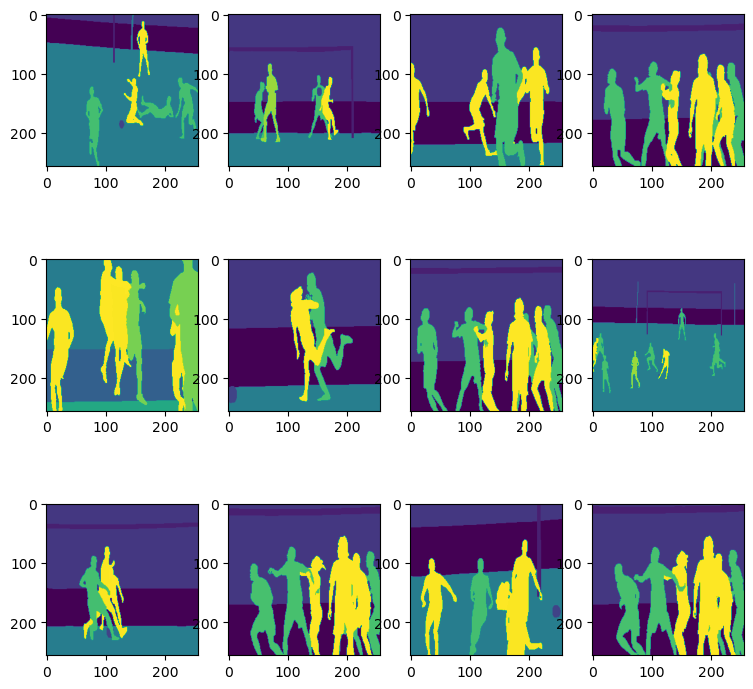

In [10]:
img = train_masks[0:12]
print("Image Train example:")
plt.figure(figsize = (9,9))

for i in range(0, 12):
    image = img[i]
    plt.subplot(3,4, i + 1)
    plt.imshow(image) 

plt.show();

In [11]:
print(train_images.shape)
print(train_masks.shape)

(80, 256, 256, 3)
(80, 256, 256)


In [12]:
def encode_labels (mask):
    ###############################################
    #Encode labels... but multi dim array so need to flatten, encode and reshape
    labelencoder = LabelEncoder()
    n, h, w = mask.shape
    mask = mask.reshape(-1,)
    masks_encoded = labelencoder.fit_transform(mask)
    masks_encoded_original_shape = masks_encoded.reshape(n, h, w)
    return masks_encoded_original_shape

In [13]:
train_masks_encoded_original_shape = encode_labels(train_masks)

np.unique(train_masks_encoded_original_shape)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [14]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
train_masks_input.shape

(80, 256, 256, 1)

In [15]:
#Further split training data t a smaller subset for quick testing of models
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size = 0.20, random_state = 0)

In [16]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [ 0  1  2  3  4  5  6  7  8  9 10]


In [17]:
print(X_train.shape)
print(y_train.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


Image Train example:


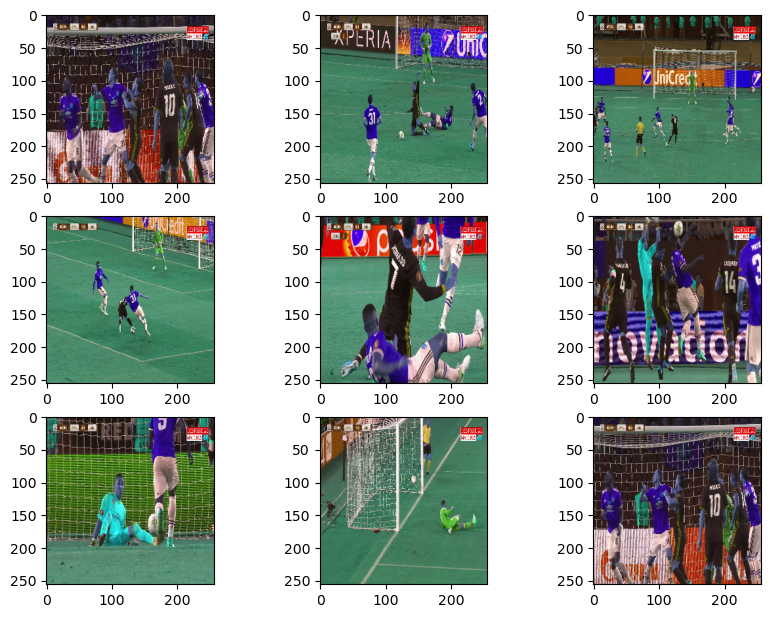

In [18]:
img = X_train[0:10]
print("Image Train example:")
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    image = img[i]
    plt.subplot(4,3, i + 1)
    plt.imshow(image) 

plt.show();

In [19]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [20]:
input_shape = (IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS )

BACKBONE1 = 'inceptionv3'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# # # preprocess input
# X_train1 = preprocess_input1(X_train)
# X_val1 = preprocess_input1(X_val)

In [21]:
def preprocess_data(img, mask,num_class,model = BACKBONE1):
    # set the pretrained model
    preprocess_input1 = sm.get_preprocessing(model)
    img = preprocess_input1(img)
    mask = to_categorical(mask,num_class)
    return (img, mask)

In [22]:
#New generator with rotation and shear where interpolation that comes with rotation and shear are thresholded in masks. 
#This gives a binary mask rather than a mask with interpolated values. 
seed=24
batch_size = 32
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(        
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

image_data_generator = ImageDataGenerator(**data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)

mask_data_generator = ImageDataGenerator(**data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)

In [23]:
def my_image_mask_generator(image_gen, mask_gen, model = "resnet50"):
    

    generator = zip(image_gen, mask_gen)
    for (img, mask) in generator:
        img , mask = preprocess_data(img,mask,n_classes,model)
        yield (img, mask)

def create_generator(X, y,model = "resnet50"): 
    image_generator = image_data_generator.flow(X,batch_size = batch_size, seed=seed)
    
    mask_generator = mask_data_generator.flow(y,batch_size = batch_size, seed=seed)
    
    generator = my_image_mask_generator(image_generator, mask_generator,model)
    return generator

my_generator = create_generator(X_train, y_train,BACKBONE1)

validation_datagen = create_generator(X_val, y_val,BACKBONE1)

(256, 256)


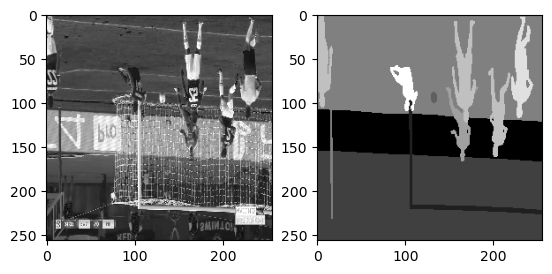

(256, 256)


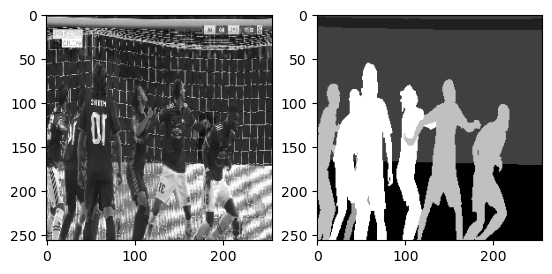

(256, 256)


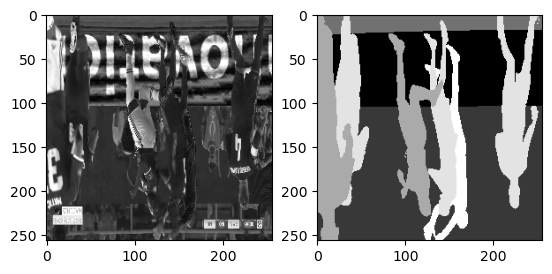

In [24]:
x ,y= my_generator.__next__()

for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    print(mask.shape)
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [25]:
print(x.shape)
print(y.shape)
print(len(np.unique(y)))

(32, 256, 256, 3)
(32, 256, 256, 11)
2


In [26]:
activation='softmax'

LR = 0.0001
def preparations():
    optim = keras.optimizers.Adam(LR)

    # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
    # set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
    weights = [1/n_classes] * n_classes
    dice_loss = sm.losses.DiceLoss(class_weights=np.array(weights)) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)
    return optim , total_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_iou_score', patience=25, verbose = 1, mode='max', restore_best_weights = True)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_iou_score',
    patience = 20,
    verbose = 1,
    factor = 0.3,
    min_lr = 0.000001)
checkpoint = keras.callbacks.ModelCheckpoint('/kaggle/working/best_model.hdf5', monitor = ['val_iou_score'], verbose = 1, mode = 'max')

In [27]:
# define model
model_gen = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)



87910968/87910968 [==============================] - 150s 2us/step


In [28]:
# compile keras model with defined optimozer, loss and metrics
optim ,total_loss =  preparations()

# model_gen.compile(optim, total_loss, metrics=metrics)
batch_size = 8
steps_per_epoch = 3*(len(X_train))//batch_size

steps_per_epoch

24

In [29]:
model_gen.compile(loss = 'categorical_crossentropy', optimizer = "Adam", metrics = [sm.metrics.IOUScore(threshold=0.5)])
history_gen = model_gen.fit(my_generator,
                            validation_data=validation_datagen,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=steps_per_epoch,
                            epochs=100,
                            callbacks= [early_stop, checkpoint]
                           )
model_gen.save("/kaggle/working/inceptionv3_0.75.keras")


Epoch 1/100


24/24 [==============================] - ETA: 0s - loss: 1.1437 - iou_score: 0.1795 
Epoch 1: saving model to /kaggle/working\best_model.hdf5


C:\Users\nadan\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 814s 31s/step - loss: 1.1437 - iou_score: 0.1795 - val_loss: 44.8597 - val_iou_score: 0.0510
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.3831 - iou_score: 0.3760 
Epoch 2: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 708s 29s/step - loss: 0.3831 - iou_score: 0.3760 - val_loss: 2.9666 - val_iou_score: 0.2486
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.2541 - iou_score: 0.4002 
Epoch 3: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 672s 28s/step - loss: 0.2541 - iou_score: 0.4002 - val_loss: 0.5893 - val_iou_score: 0.3100
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.1933 - iou_score: 0.4647 
Epoch 4: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 657s 28s/step - loss: 0.1933 - iou_score: 0.4647 - val_loss: 0.4627 - val_iou_score: 0.3487
Epoch

Epoch 30/100
24/24 [==============================] - ETA: 0s - loss: 0.0244 - iou_score: 0.8664 
Epoch 30: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 766s 32s/step - loss: 0.0244 - iou_score: 0.8664 - val_loss: 0.1227 - val_iou_score: 0.7282
Epoch 31/100
24/24 [==============================] - ETA: 0s - loss: 0.0237 - iou_score: 0.8641 
Epoch 31: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 754s 32s/step - loss: 0.0237 - iou_score: 0.8641 - val_loss: 0.1239 - val_iou_score: 0.7290
Epoch 32/100
24/24 [==============================] - ETA: 0s - loss: 0.0224 - iou_score: 0.8697 
Epoch 32: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 724s 30s/step - loss: 0.0224 - iou_score: 0.8697 - val_loss: 0.1265 - val_iou_score: 0.7278
Epoch 33/100
24/24 [==============================] - ETA: 0s - loss: 0.0224 - iou_score: 0.8699 
Epoch 33: saving model to /kaggle/w

24/24 [==============================] - ETA: 0s - loss: 0.0129 - iou_score: 0.8845 
Epoch 58: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 963s 40s/step - loss: 0.0129 - iou_score: 0.8845 - val_loss: 0.1612 - val_iou_score: 0.7266
Epoch 59/100
24/24 [==============================] - ETA: 0s - loss: 0.0150 - iou_score: 0.8813 
Epoch 59: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 925s 39s/step - loss: 0.0150 - iou_score: 0.8813 - val_loss: 0.1554 - val_iou_score: 0.7336
Epoch 60/100
24/24 [==============================] - ETA: 0s - loss: 0.0139 - iou_score: 0.8859 
Epoch 60: saving model to /kaggle/working\best_model.hdf5
24/24 [==============================] - 882s 37s/step - loss: 0.0139 - iou_score: 0.8859 - val_loss: 0.1583 - val_iou_score: 0.7271
Epoch 61/100
24/24 [==============================] - ETA: 0s - loss: 0.0129 - iou_score: 0.8844 
Epoch 61: saving model to /kaggle/working\best_m

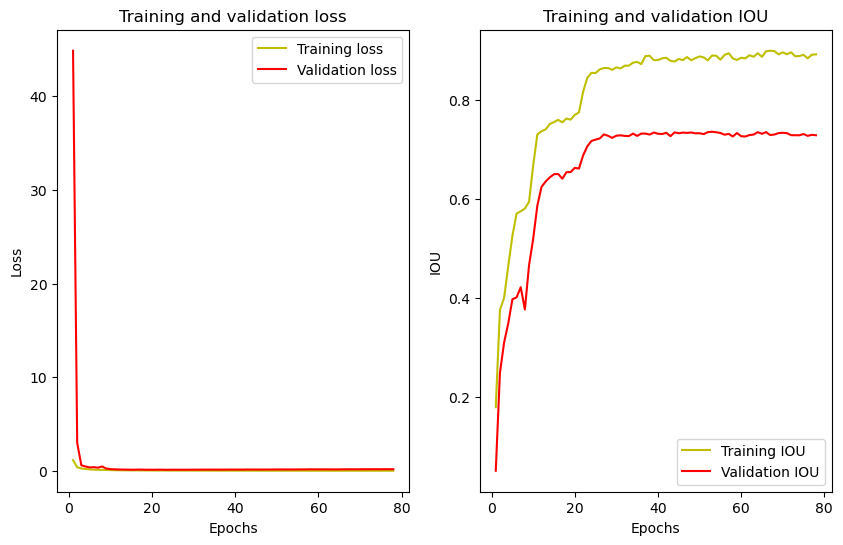

In [30]:
#plot the training and validation accuracy and loss at each epoch
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
loss = history_gen.history['loss']
val_loss = history_gen.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
acc = history_gen.history['iou_score']
val_acc = history_gen.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

1/1 [==============================] - 8s 8s/step


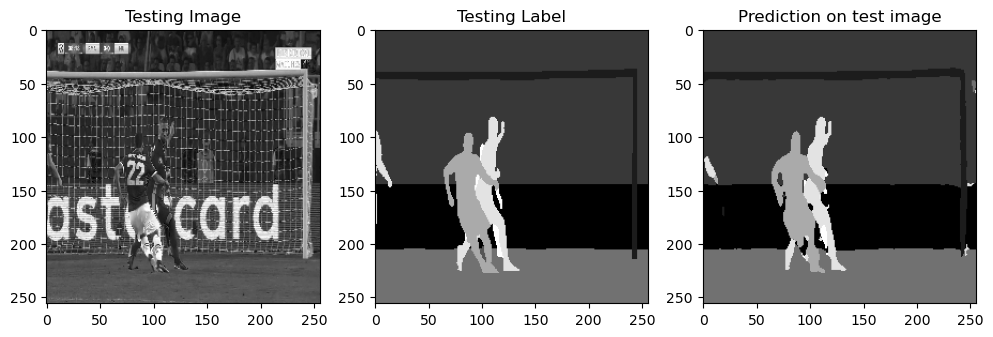

In [31]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_val))
test_img = X_val[test_img_number]
ground_truth=y_val[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input1(test_img_input)

test_pred1 = model_gen.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [32]:
def create_test():
    test_images = load_images(test_images_p,256,256)
    X_test = np.array(test_images)
#     X_test = np.stack((test_images,) * 3, axis = -1)
    
    test_maskes= load_masks(test_masks_p,256,256)
    test_maskes = np.array(test_maskes)

    y_test = encode_labels(test_maskes)
    y_test = np.expand_dims(y_test, axis=3)
    
    return X_test , y_test

X_test , y_test = create_test()

In [33]:
def create_test_generator(X, y,model = BACKBONE1): 
    data_gen_args = dict()
    test_img_datagen = ImageDataGenerator(**data_gen_args)
    test_img_datagen.fit(X, augment=True, seed=seed)
    
    test_mask_data_generator = ImageDataGenerator(**data_gen_args)
    test_mask_data_generator.fit(y, augment=True, seed=seed)
    
    img_generator = test_img_datagen.flow(X,batch_size = batch_size, seed=seed)
    
    mask_generator = test_mask_data_generator.flow(y,batch_size = batch_size, seed=seed)
    
    generator = my_image_mask_generator(image_generator, mask_generator,model)
    return generator

test_datagen = create_generator(X_test, y_test,BACKBONE1)
X_test = preprocess_input1(X_test)

In [34]:
print(X_test.shape)
print(y_test.shape)

(20, 256, 256, 3)
(20, 256, 256, 1)


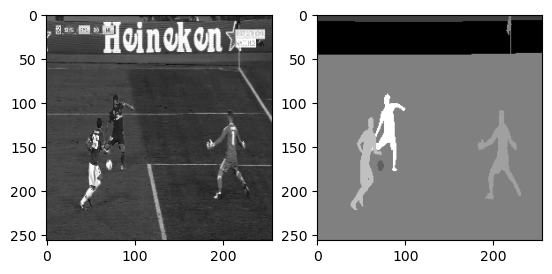

In [35]:
for i in range(0,1):
    image = X_test[i]
    mask = y_test[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

1/1 [==============================] - 0s 299ms/step


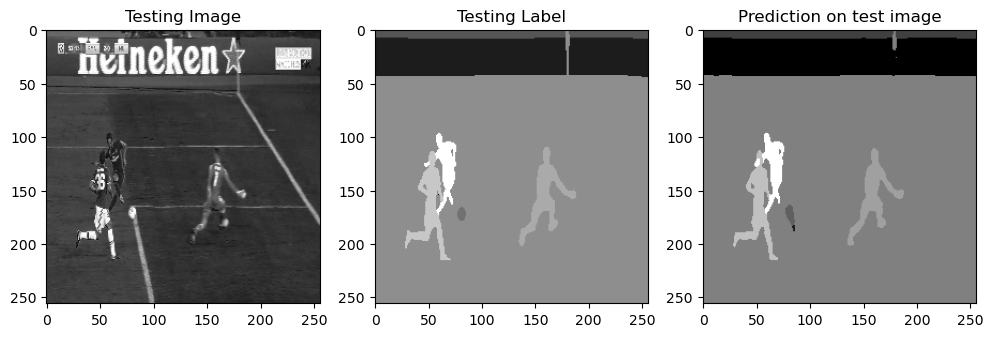

In [36]:
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)

test_pred1 = model_gen.predict(test_img_input)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [37]:
model_gen.evaluate(test_datagen,steps= steps_per_epoch)

24/24 [==============================] - 34s 1s/step - loss: 0.1370 - iou_score: 0.7737


[0.13699260354042053, 0.7736914753913879]

In [38]:
#IOU
y_pred1=model_gen.predict(X_test)
y_pred1_argmax=np.argmax(y_pred1, axis=3)


#Using built in keras function
#from keras.metrics import MeanIoU
n_classes = 11
IOU_keras = keras.metrics.MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred1_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
classes_iou = []
for i in range(n_classes):
    s = values[i,i]
    sum = values[i,i]
    for j in range(n_classes):
        if i == j:
            continue
        sum+= values[i,j]
        sum+= values[j,i]

    iou = s/sum
    classes_iou.append(iou)

1/1 [==============================] - 4s 4s/step
Mean IoU = 0.73635346


Text(0.5, 1.0, 'IOU for each class')

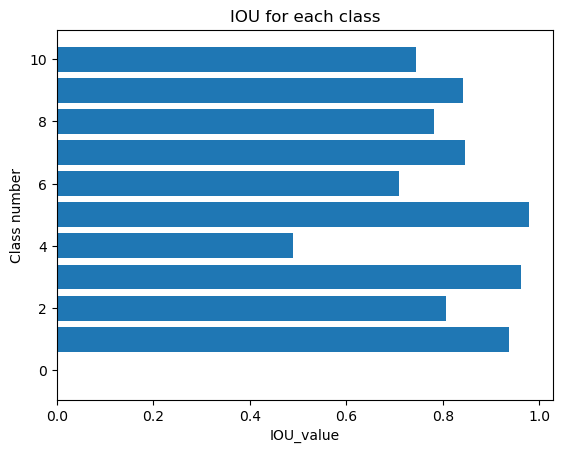

In [39]:
plt.barh(range(0,11),classes_iou)
plt.xlabel("IOU_value")
plt.ylabel("Class number")
plt.title("IOU for each class")